## テスト用

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import numpy as np
import scipy.stats as stats
from datagenerator import xy_data_generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
%matplotlib inline
import seaborn as sns
sns.set()

### 人口データ作成用datagenerator
任意の平均値、分散を持つ任意の分布からサンプリングすることをしたい
p(y|x, sigma(x)^2)からサンプリングしたいってこと

In [132]:
norm = stats.norm
def mu(x):
    #from [Takeuchi et.al, 2003]
#     return np.sinc(x)
    return x*np.sin(x)

def sigma(x):
    return 1*np.exp(1-x)

In [133]:
gen=xy_data_generator(mu,sigma,norm)
gen.start=0
gen.stop=5

start 0 stop 3 
you can change these parameter


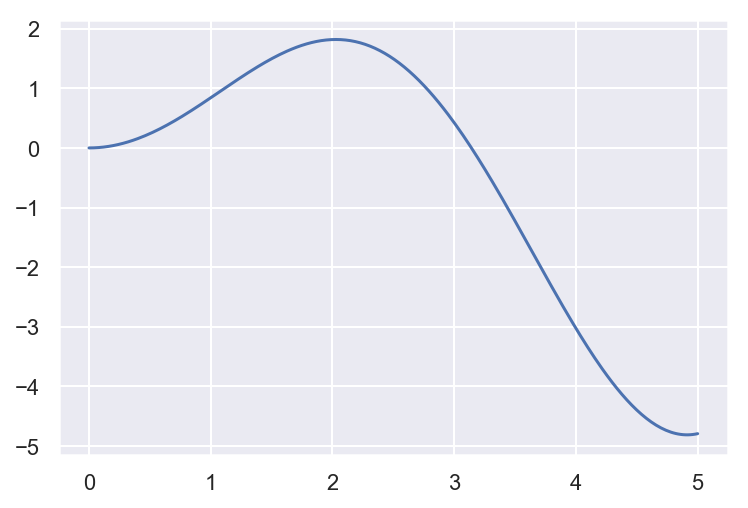

In [134]:
gen.show_mu()

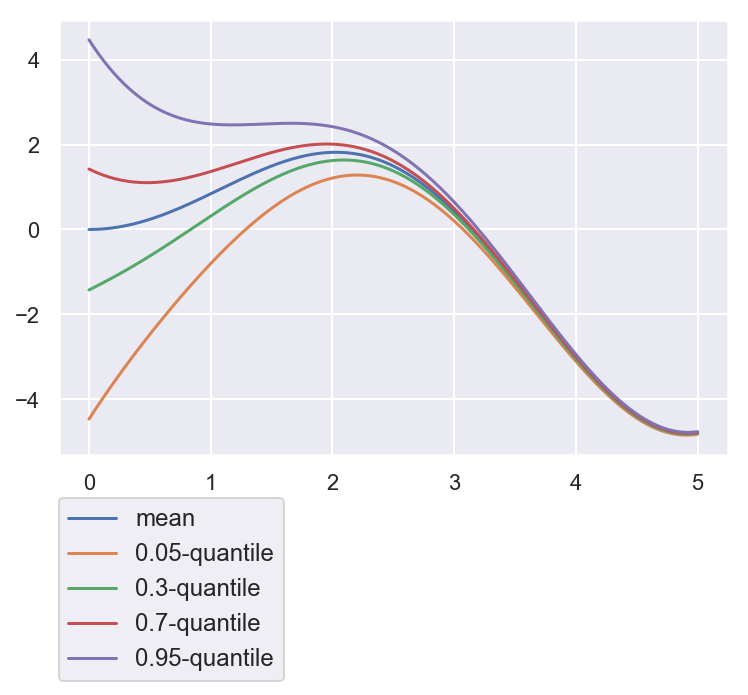

In [135]:
gen.show_t_quantile()

### データのランダム生成

In [136]:
X, Y=gen.n_sample(n=500)

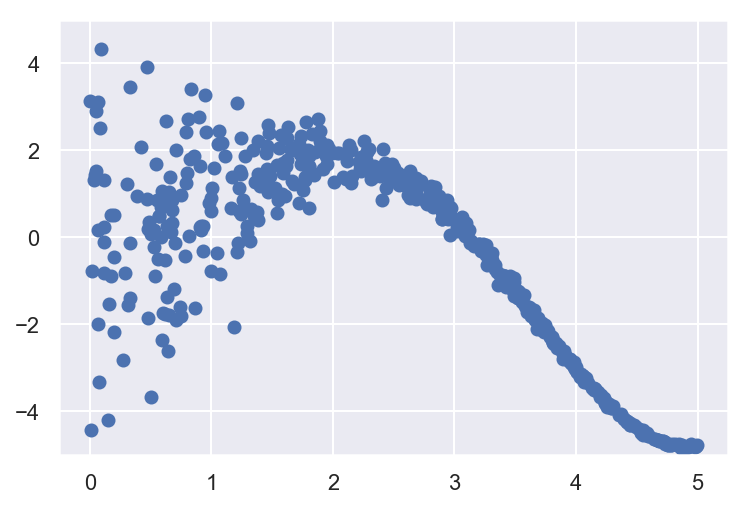

In [137]:
plt.scatter(X,Y)
plt.ylim(-5,5);

## PyTorchゾーン

### モデルの構築
お試しに超シンプルなモデル

In [138]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


net = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
#     nn.Sigmoid(),
    nn.Dropout(0.3),
    nn.Linear(32, 16),
    nn.ReLU(),
#     nn.Sigmoid(),
    nn.Dropout(0.3),
    nn.Linear(16, 1)
)

# ソフトマックスクロスエントロピー
loss_fn = nn.MSELoss()

# Adam
optimizer = optim.Adam(net.parameters(),lr=5e-4)

# NumPyのndarrayをPyTorchのTensorに変換
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)


# Datasetを作成
ds = TensorDataset(X, Y)

# 異なる順番で64個ずつデータを返すDataLoaderを作成
loader = DataLoader(ds, batch_size=32, shuffle=True)



In [139]:
# 損失関数のログ
losses = []

net.train()

# 100回イテレーションを回す
for epoc in range(500):
    if not epoc%50:
        print(epoc)
#         print(loss)
    runningloss=0.0
    for i, (xx, yy) in enumerate(loader):
        # 前回のbackwardメソッドで
        # 計算された勾配の値を削除
        optimizer.zero_grad()

        # 線形モデルでyの予測値を計算
        y_pred = net(xx)

        # MSE lossとwによる微分を計算
        loss = loss_fn(y_pred, yy)
        loss.backward()

        # 勾配を更新する
        optimizer.step()

        # 収束確認のためにlossを記録しておく
        runningloss+=loss.item()
    losses.append(runningloss/i)

0
50
100
150
200
250
300
350
400
450


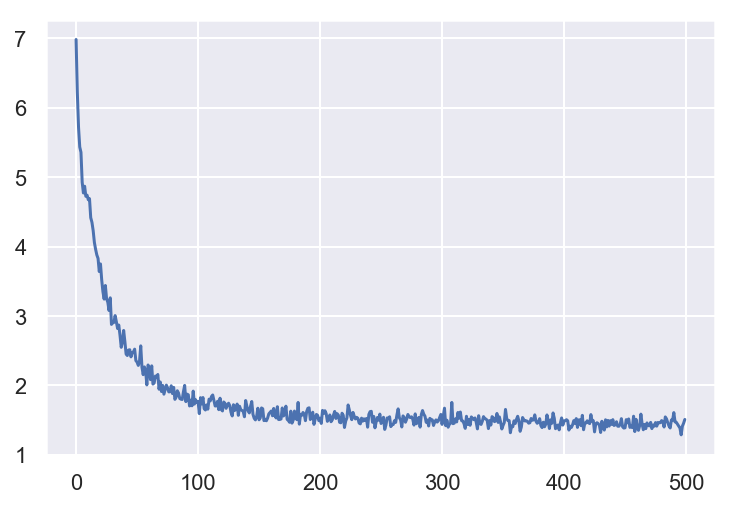

In [140]:
plt.plot(losses)

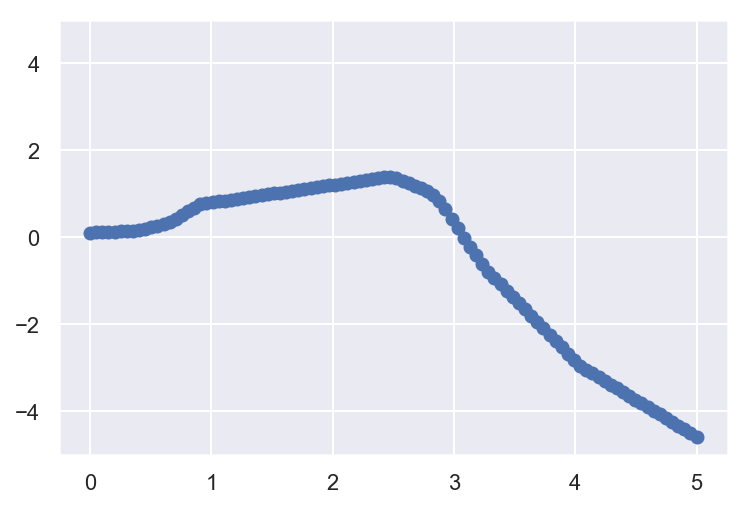

In [141]:
net.eval()

Y_pred=net(torch.tensor(np.linspace(0,5,100).reshape(100,1),dtype=torch.float32))

plt.scatter(np.linspace(0,5,100),Y_pred.detach())
plt.ylim(-5,5);

### 分位点回帰

In [142]:
class qrnn(nn.Module):
    def __init__(self,
                 quantiles,
                 in_shape=1,
                 dropout=0.1):
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.dropout = dropout
        self.in_shape = in_shape
        self.out_shape = len(quantiles)

        self.build_model()
        
    def build_model(self): 
        self.model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(self.dropout),
            nn.Linear(128, self.out_shape) #最後のノード数だけもつ層を作る
        )
        
    def forward(self, x):
        return self.model(x)

class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
#             print(errors)
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
#             print(losses)
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss



In [143]:
net=qrnn(quantiles=[0.5])

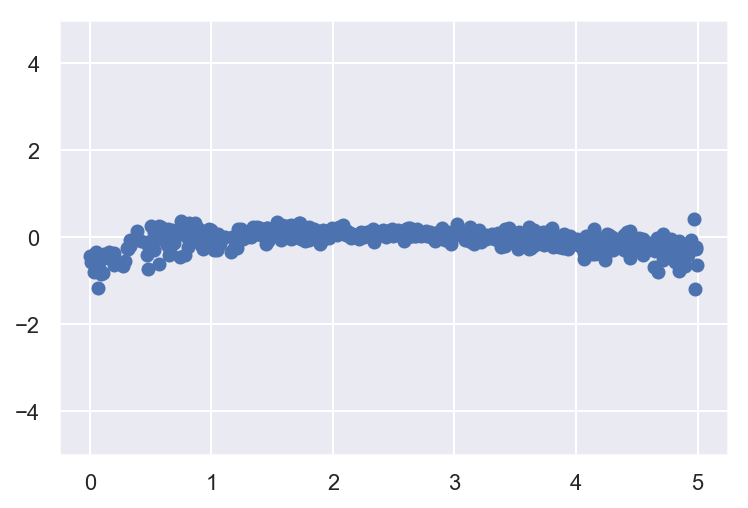

In [144]:
plt.scatter(X,net(X)[:,0].detach())
# plt.scatter(X,net(X)[:,1].detach())
# plt.scatter(X,net(X)[:,2].detach())
plt.ylim(-5,5);

In [145]:
X.shape ,net(X).shape

(torch.Size([500, 1]), torch.Size([500, 1]))

In [157]:
loss_fn = QuantileLoss(quantiles=[0.5])

# Adam
optimizer = optim.Adam(net.parameters(),lr=5e-5)

# Datasetを作成
ds = TensorDataset(X, Y)

# 異なる順番で64個ずつデータを返すDataLoaderを作成
loader = DataLoader(ds, batch_size=32, shuffle=True)

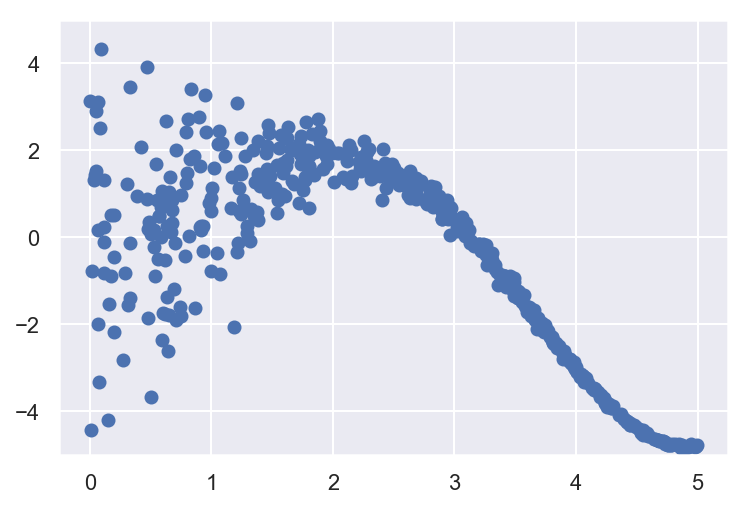

In [161]:
plt.scatter(X,Y)
plt.ylim(-5,5);

In [158]:
# 損失関数のログ
losses = []

net.train()

# 100回イテレーションを回す
for epoc in range(500):
    if not epoc%50:
        print(epoc)
#         print(loss)
    runningloss=0.0
    for i, (xx, yy) in enumerate(loader):
        # 前回のbackwardメソッドで
        # 計算された勾配の値を削除
        optimizer.zero_grad()
        
        y_pred = net(xx)

        # wによる微分を計算
        loss = loss_fn(y_pred, yy)
        loss.backward()

        # 勾配を更新する
        optimizer.step()

        # 収束確認のためにlossを記録しておく
        runningloss+=loss.item()
    losses.append(runningloss/i)

0
50
100
150
200
250
300
350
400
450


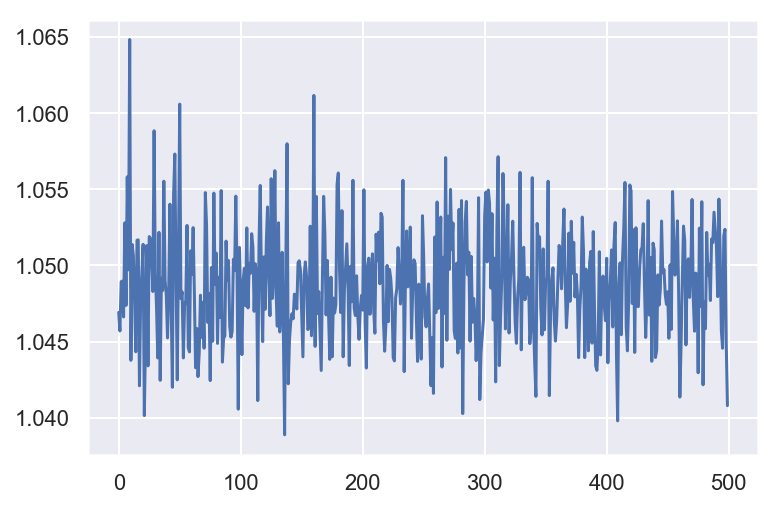

In [159]:
plt.plot(losses)

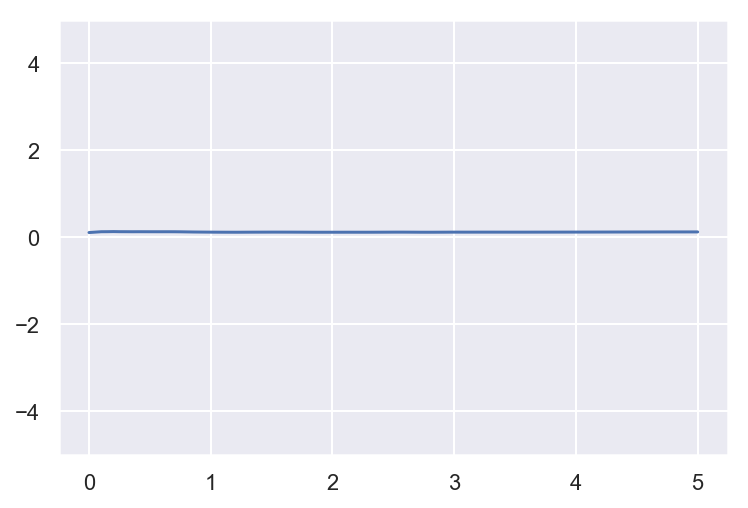

In [160]:
net.eval()
plt.plot(np.linspace(0,5,100),net(torch.Tensor(np.linspace(0,5,100).reshape(100,1))).detach()[:,0].numpy())
# plt.scatter(X,net(X)[:,1].detach())
# plt.scatter(X,net(X)[:,2].detach())
plt.ylim(-5,5);

In [154]:
net(torch.Tensor(np.linspace(0,5,100).reshape(100,1))).detach()[:,0].numpy()

array([0.11048616, 0.13201348, 0.13441783, 0.12345084, 0.11199837,
       0.10648575, 0.10888936, 0.11018935, 0.11014441, 0.10873636,
       0.10864605, 0.10903538, 0.11021014, 0.11282992, 0.11610331,
       0.11834491, 0.11981837, 0.12013675, 0.11914799, 0.1178334 ,
       0.11658759, 0.11534081, 0.11452653, 0.11396099, 0.11407559,
       0.1147077 , 0.1162597 , 0.11836997, 0.11998238, 0.12071533,
       0.121002  , 0.12128868, 0.12178681, 0.12238934, 0.12202009,
       0.12095355, 0.11988003, 0.11897897, 0.11841924, 0.11856586,
       0.11876083, 0.11927366, 0.11962443, 0.11960245, 0.11923716,
       0.11865307, 0.11818925, 0.11804976, 0.11787234, 0.11842457,
       0.11958695, 0.12074245, 0.12079956, 0.12062437, 0.12022892,
       0.11918754, 0.11862799, 0.11894291, 0.11946578, 0.11982899,
       0.12029109, 0.12029666, 0.12020802, 0.12031705, 0.12051804,
       0.12090113, 0.1209401 , 0.12071557, 0.12077276, 0.12082992,
       0.12090156, 0.12108419, 0.12124649, 0.12146453, 0.12170